In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
/*================================================================
*   Copyright (C) 2017. All rights reserved.
*   Author：Leon Wang
*   Date：Sun Mar 26 21:19:35 2017
*   Email：leonwang@bu.edu
*   Description： Long_Term_Short_Term Memory Neural Network to predict the alpha returns
================================================================*/
"""
import pandas as pd
import os
import re
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
class rolling_list():
    """
        Object to arrange original data into LSTM input format
    """
    def __init__(self, rolling_window,data,label='NA',pred=[]):
        """
            Method to initialize the original data object
            :params rolling_window, interger, number of days in calculating the Rolling Window
            :params data, pd.DataFrame, contains n_obs x [Emotions, Returns]
        """
        self.rolling_window=rolling_window
        self.data=data
        self.length=int(len(data)/rolling_window)
        self.label=label
        self.pred=pred
    def sequence(self):
        """ Method to generate a List of DataFrame for seperated by each date.
            :return, List of pd.DataFrame, with List length= self.length and DataFrame length of self.rolling_window
        """
        List=[]
        for i in range(len(self.data)-rolling_window):
            List.append(self.data[i:i+self.rolling_window])
        return List
    def recover_alpha(self):
        """
            Method to generate a List of DataFrame seperated by each date.
            :return
        """
        List=[]
        for i in range(len(self.data)-rolling_window):
            without_today=self.data[self.label][i:i+self.rolling_window-1]
            List.append((sum(without_today)+self.pred[i])/self.rolling_window)
        return List

In [3]:
def e_d_dist(x,y):
    value=0
    for i in range(len(x)):
        value+=(x[i]-y[i])**2
    return value
distance=[]

In [4]:
def get_stock_dict(indi_stock_dir,index_stock_dir,rolling_window=15):
    """
        Function to return a dictionary of stocks with tickers to be the key
        : params indi_stock_dir, individual stock directory, contains mutiple files
        : params index_stock_dir, index stock directory, ending with csv
        : return a dictionary of stocks with:
                    * tickers to be the key 
                    * A 2d-list sorted by date. The List contains individual stock return and index return.
        : Example: {'JPM':[['2014-09-15',-0.1584,0.0050],['2014-09-16',-0.1692,0.0075]...etc]}
    """
    # Load the file name 
    for dira,path,files in os.walk(indi_stock_dir):
        1+1
    # Regular Expression to extract stock tickers
    regex='financial_data_(.*?)\.csv'
    pat=re.compile(regex,re.S)
    name=set(pat.findall(str(files)))
    
    # Read the index_stock data, store it as x for regression
    x=pd.read_csv(index_stock_dir,index_col=0)['CLOSE']
    x=x.diff(1)
    x=sm.add_constant(x)
    
    
    stock_dict={}
    stock_dict_w_o_t={}
    
    for stocks in name:
        temp_List=[]
        temp_List2=[]
        y=pd.read_csv('Twitter_sentiment_DJIA30/financial_data_'+str(stocks)+'.csv',index_col=0)['CLOSE']
        y=y.dropna(how="any")
        temp=pd.concat([x,y.diff(1)],axis=1).dropna(how="any")
        temp.columns=['const','Close_x','Close_y']
        observ_num=len(temp)
        for i in range(observ_num-rolling_window):
            # First Modeing fitting
            model = sm.OLS(temp['Close_y'].iloc[i:i+rolling_window],temp[['const','Close_x']].iloc[i:i+rolling_window]).fit()
            
            # Store the data in the order of [Date, Alpha, Beta]
            temp_List.append([temp.index[rolling_window+i],model.params['const'],model.params['Close_x']])
            
            # Second Modeling fitting
            model = sm.OLS(temp['Close_y'].iloc[i:i+rolling_window-1],temp[['const','Close_x']].iloc[i:i+rolling_window-1]).fit()

            # Store the data in the order of [Date, Alpha, Beta]
            temp_List2.append([temp.index[rolling_window+i],model.params['const'],model.params['Close_x']])
        stock_dict.update({stocks:temp_List})
        stock_dict_w_o_t.update({stocks:temp_List2})
    return stock_dict, stock_dict_w_o_t

def agg_tables(stock_dict):
    """
        Function to return alpha_table,beta_table,emotion_table
        : param stock_dict, a dictionary of stocks with:
                    * tickers to be the key 
                    * A 2d-list sorted by date. The List contains individual stock return and index return.
          Example: {'JPM':[['2014-09-15',-0.1584,0.0050],['2014-09-16',-0.1692,0.0075]...etc]}

        : return alpha_table, pd.DataFrame, indexed with datadate, columned with stock tickers, content with the Alpha in regression model
                 beta_table, pd.DataFrame, indexed with datadate, columned with stock tickers, content with the Beta in regression model
                 emotion_table, pd.DataFrame,indexed with datadate, columned with stock tickers, content with the Emotions in regression model
    """
    ticker_names=list(stock_dict.keys())
    ticker_names.remove('DJIA')
    init_date=[every_obs[0] for every_obs in stock_dict[ticker_names[0]]]
    
    emotion_table=pd.DataFrame(index=init_date,columns=ticker_names)
    alpha_table=pd.DataFrame(index=init_date,columns=ticker_names)
    beta_table=pd.DataFrame(index=init_date,columns=ticker_names)
    
    for ticker in ticker_names:
        date=[every_obs[0] for every_obs in stock_dict[ticker]]
        alpha=[alpha[1] for alpha in stock_dict[ticker]]
        beta=[beta[2] for beta in stock_dict[ticker]]
        
        tw_emotion=pd.read_csv('Twitter_sentiment_DJIA30/twitter_data_'+str(ticker)+'.csv',index_col=0)
        tw_emotion=tw_emotion[['NUM_NEG','NUM_POS','NUM_NEU']]
        profession_emotion=pd.read_csv('Rating/'+str(ticker.lower())+'.csv',index_col=0)['Rating']
        profession_emotion.index=pd.to_datetime(profession_emotion.index)
        profession_emotion.dropna(how='any')
        for m in range(len(date)):
            alpha_table[ticker].loc[date[m]]=alpha[m]
            beta_table[ticker].loc[date[m]]=beta[m]
            emotion_table[ticker].loc[date[m]]=np.hstack((tw_emotion.loc[date[m]].values,profession_emotion.loc[date[m]].values))

    return alpha_table,beta_table,emotion_table


In [5]:
indi_stock_dir='Twitter_sentiment_DJIA30'
index_stock_dir='financial_data_DJIA.csv'
stock_dict,stock_dict_w_o_t=get_stock_dict(indi_stock_dir,index_stock_dir,15)

In [ ]:
a,b,emotion_table=agg_tables(stock_dict)
a_w_o_t,b_w_o_t,emotion_table_w_o_t=agg_tables(stock_dict_w_o_t)

ticker_names=list(stock_dict.keys())

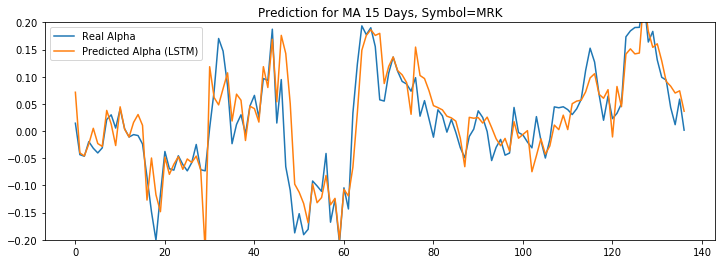

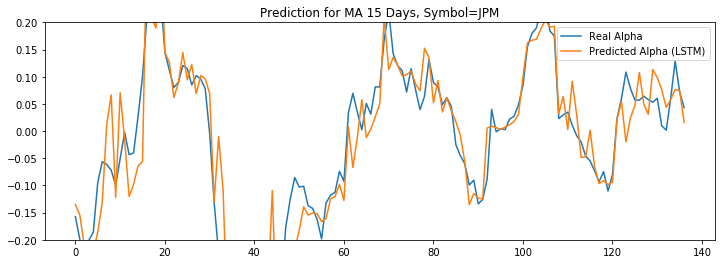

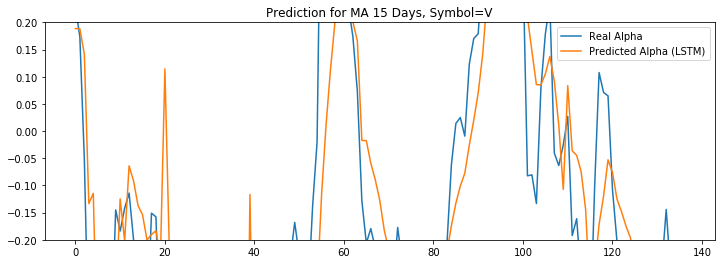

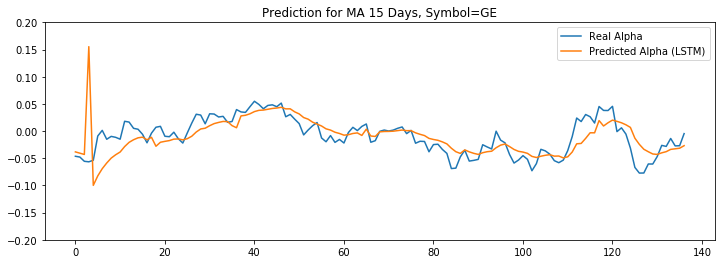

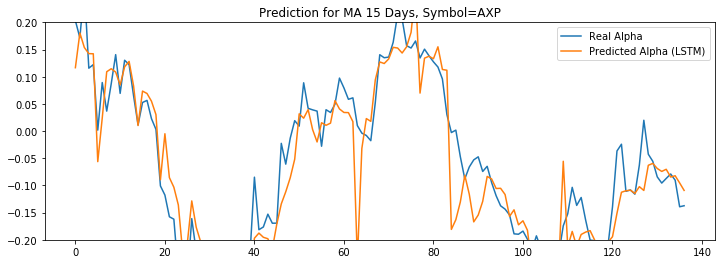

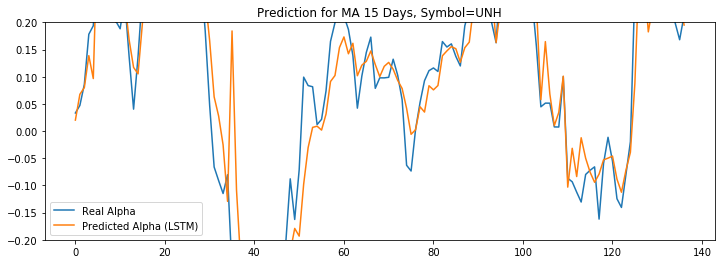

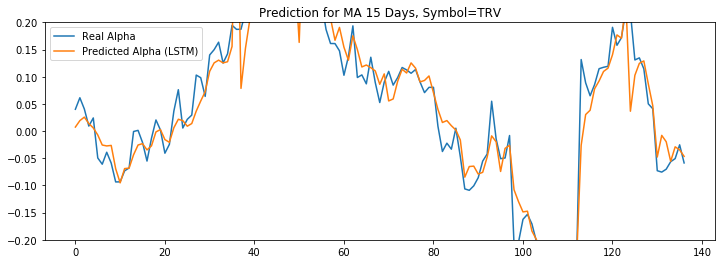

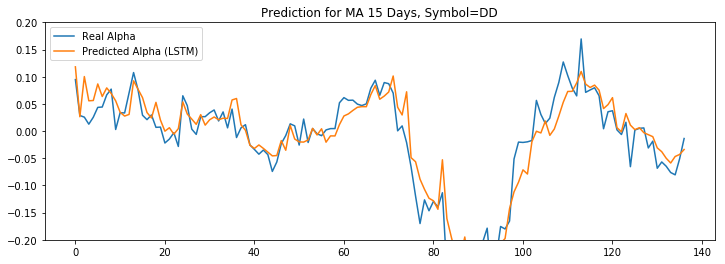

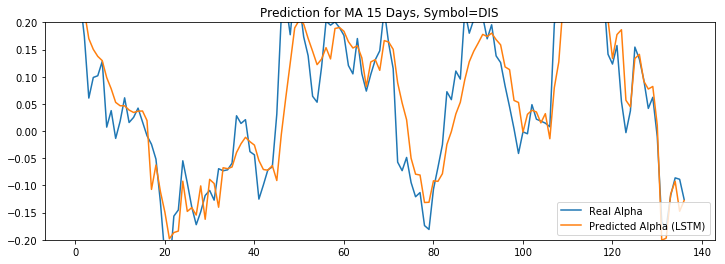

In [ ]:
import tensorflow as tf
### Setting Up Parameters #1
rolling_window=15
biases=0.1
n_inputs=4
n_hidden_units=50
class_num=1
nsteps=rolling_window
lr=0.01

### Setting Up Parameters #2
sess = tf.InteractiveSession()
weight={'in': tf.Variable(tf.random_normal([n_inputs, n_hidden_units],0,n_inputs**(-1/2))),
        'out': tf.Variable(tf.random_normal([n_hidden_units, class_num],0,n_hidden_units**(-1/2)))
                    }
biases = {'in': tf.Variable(tf.constant(biases, shape=[n_hidden_units, ])),
          'out': tf.Variable(tf.constant(biases, shape=[class_num, ]))
                    }
x=tf.placeholder(tf.float32, [nsteps, n_inputs])
y=tf.placeholder(tf.float32, [class_num])



### Setting Up Training
x_in=tf.matmul(x,weight['in'])+biases['in']
x_in=tf.reshape(x_in,[1,nsteps,n_hidden_units])

cell=tf.nn.rnn_cell.BasicLSTMCell(n_hidden_units, forget_bias=1.0, state_is_tuple=True)
init_state = cell.zero_state(1, dtype=tf.float32)

outputs, final_state = tf.nn.dynamic_rnn(cell, x_in, initial_state=init_state, time_major=False)

predict = tf.matmul(final_state[1], weight['out']) + biases['out']
squared_deltas = tf.square(predict - y)

cost = tf.reduce_mean(squared_deltas)


optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(cost)

init = tf.global_variables_initializer()
sess.run(init)


sep_point=150
analysis=pd.concat([emotion_table['AXP'],a['AXP']],axis=1).dropna(how="any")
analysis.columns=['Emotion','Return']
indexs=analysis.index[rolling_window+sep_point:]
agg_table=pd.DataFrame(index=indexs)

for m in ticker_names[1:]:
    analysis=pd.concat([emotion_table[m],a[m]],axis=1).dropna(how="any")
    analysis.columns=['Emotion','Return']
    pred_alpha=[]
    pred_beta=[]
    real_alpha=[]
    real_beta=[]
    sess.run(init)
    for i in rolling_list(rolling_window,analysis).sequence():
        x_batch=[list(w) for w in i['Emotion'].values]
        x_batch=np.array(x_batch)
        y_batch=np.array(i[['Return']].values[-1]).reshape(class_num,)
        sess.run(train,feed_dict={x:x_batch,y:y_batch})
        
        pred_alpha.append(sess.run(predict,feed_dict={x:x_batch,y:y_batch})[0][0])
        real_alpha.append(y_batch[0])
    plt.figure(figsize=(12,4))
    plt.plot(range(len(real_alpha[sep_point:])),real_alpha[sep_point:],label='Real Alpha')
    plt.plot(range(len(pred_alpha[sep_point:])),pred_alpha[sep_point:],label='Predicted Alpha (LSTM)')
    plt.ylim((-0.2, 0.2))
    plt.legend()   
    plt.title('Prediction for MA '+str(rolling_window)+' Days, Symbol='+str(m)+'')
    plt.show()
    ### Recover the alpha
#    agg_table[m]=rolling_list(rolling_window,analysis,'Return',prediction).recover_alpha()[sep_point:]
    
    agg_table[m]=pred_alpha[sep_point:]
    distance.append(e_d_dist(real_alpha[sep_point:],pred_alpha[sep_point:]))
"""
agg_table.to_csv("agg_table.csv")
decision=agg_table-table_m_o
decision=decision.drop('DJIA',axis=1)
decision=decision.dropna(how='any')
decision=decision>0.1
decision=decision[:-1]

### Begin 22
real_return=pd.DataFrame()
name=set(pat.findall(str(files)))
for stocks in name:
    y=pd.read_csv('Twitter_sentiment_DJIA30/financial_data_'+str(stocks)+'.csv',index_col=0)['CLOSE']
    y=y.diff(1)[1:]/y[:-1].values
    y=y.dropna(how="any")
    real_return[stocks]=y
real_return=real_return.dropna(how='any')
index_return=real_return['DJIA']
real_return=real_return.drop('DJIA',axis=1)
beta_table=beta_table.sort_index(axis=1)
beta_table=beta_table.drop('DJIA',axis=1)
real_return=real_return.sort_index(axis=1)

indexs=list(name)
indexs.remove("DJIA")
distance=pd.DataFrame(distance,index=indexs)
distance=distance.sort_index(axis=1)
bad_prediction=distance[distance>3].dropna(how='any').index
distance.plot()
plt.show()
return_continous_port=[]
return_continous_index=[]
cmre=1
cmre_index=1
### drop bad prediction
decision=decision.drop(bad_prediction,axis=1)
real_return=real_return.drop(bad_prediction,axis=1)
beta_table=beta_table.drop(bad_prediction,axis=1)
### end of dropping
for i in decision.index:
    boolen=decision.loc[i]==True
    ###
    long=np.mean(real_return.loc[i][boolen]+beta_table.loc[i][boolen]*index_return.loc[i])
    #beta_table.loc[i][boolen]
    boolen=boolen==False
    short=np.mean(real_return.loc[i][boolen]+beta_table.loc[i][boolen]*index_return.loc[i])
#    cmre*=1+(long-short)
    cmre*=1+(long-short)
    return_continous_port.append(cmre)
    
    cmre_index*=1+index_return.loc[i]
    return_continous_index.append(cmre_index)


plt.plot(return_continous_index,label="Index")
plt.plot(return_continous_port,label="Portfolio")
plt.legend()

"""